# Example Notebook for Tektronix Keithley 2450 source meter

In this example we will setup a number of [four-wire measurements](https://en.wikipedia.org/wiki/Four-terminal_sensing) with the 2540 source meter. We attach a variable resistor to the front terminals and determine if we can measure the correct resistance.

In [15]:
from qcodes import new_experiment
from qcodes.instrument_drivers.tektronix.Keithley_2450 import Keithley2450, ParameterError
from qcodes.dataset.database import initialise_database
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id

In [2]:
keithley = Keithley2450("keithley", "GPIB0::18::INSTR")

Connected to: KEITHLEY INSTRUMENTS 2450 (serial:04397524, firmware:1.6.4c) in 0.03s


## Single point measurements 

Attach a variable resistor to the front and source a current 

In [3]:
keithley.terminals("FRONT")
keithley.source.function("current")
keithley.source.current(1E-6)  # Put 1uA through the resistor 
current_setpoint = keithley.source.current()

voltage = keithley.sense.function("voltage")
keithley.output(True)
voltage = keithley.sense.voltage()
keithley.output(False)

print(f"Approx. resistance: ",  voltage/current_setpoint)

Approx. resistance:  1020.958


In 'current' mode, we cannot set/get a voltage and vis-versa

In [8]:
try: 
    keithley.source.voltage()
except ParameterError as err: 
    print(err)

'keithley.source.function()=current'Please run 'keithley.source.function(voltage)' and try again


This goes for both the source and sense subsystems 

In [10]:
try: 
    voltage = keithley.sense.current()
except ParameterError as err: 
    print(err)

'keithley.sense.function()=voltage'Please run 'keithley.sense.function(current)' and try again


We also need to make sure the output is enabled for use the measure (or 'sense') a current or voltage 

In [11]:
try: 
    voltage = keithley.sense.voltage()
except ParameterError as err: 
    print(err)

'keithley.output()=False'Please run 'keithley.output(True)' and try again


## Sweeping measurements 

The instrument has a build-in sweep system. For the first measurement, we drive a current through the resistor and measure the voltage accross it. 

In [4]:
keithley.source.function("current")
keithley.source.auto_range(True)
keithley.source.limit(0.2)

keithley.sense.function("voltage")
keithley.sense.auto_range(True)

keithley.sense.four_wire_measurement(True)

In [ ]:
initialise_database()

Sweep the current from 0 to 1uA in 10 steps

In [29]:
def setup(start, stop, step): 
    keithley.sweep.setup(start, stop, step)
    keithley.output(True)

In [30]:
def cleanup(): 
    keithley.output(True)

In [31]:
experiment = new_experiment("simple_resistor", "1kOhm_2")
meas = Measurement(exp=experiment)
meas.register_parameter(keithley.sweep, paramtype='array')

meas.add_before_run(setup, (0, 10E-6, 10))
meas.add_after_run(cleanup, ())

In [32]:
with meas.run() as datasaver:    
    datasaver.add_result((keithley.sweep, keithley.sweep()))

Starting experimental run with id: 4


([<matplotlib.axes._subplots.AxesSubplot at 0x168620716a0>], [None])

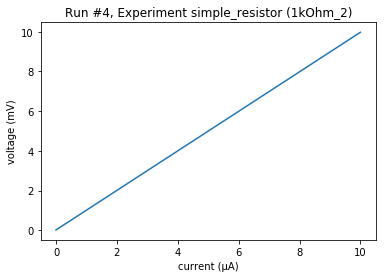

In [33]:
plot_by_id(datasaver.run_id)

We see from the slope that we have a 1kOhm resistance (which is correct). Next, lets increase the resistance to 3kOhm

DataSet:
   location = 'data/2019-04-16/#015_{name}_17-00-57'
   <Type>   | <array_id>     | <array.name> | <array.shape>
   Measured | keithley_sweep | sweep        | (10,)
acquired at 2019-04-16 17:00:58


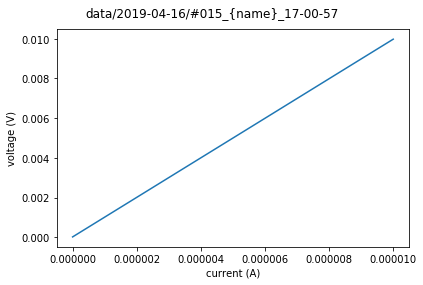

In [14]:
keithley.sweep.setup(0, 10E-6, 10)
keithley.output(True)
data = Measure(keithley.sweep).run()
keithley.output(False)
MatPlot(data.arrays['keithley_sweep'])

We indeed see that the resistance has increased to 3kOhm. Now we will turn the resistance back to 1kOhm and sweep the voltage and measure the current 

In [17]:
keithley.sense.function("current")
keithley.sense.range(1E-5)
keithley.sense.four_wire_measurement(True)
keithley.source.function("voltage")
keithley.source.range(0.2)
keithley.source.limit(0.001)

DataSet:
   location = 'data/2019-04-16/#016_{name}_17-01-27'
   <Type>   | <array_id>     | <array.name> | <array.shape>
   Measured | keithley_sweep | sweep        | (10,)
acquired at 2019-04-16 17:01:28


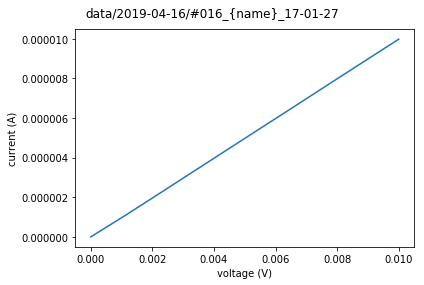

In [18]:
keithley.sweep.setup(0, 0.01, 10)
keithley.output(True)
data = Measure(keithley.sweep).run()
keithley.output(False)
MatPlot(data.arrays['keithley_sweep'])